# BLM calculator

Steps in this pipeline:
1. Run the same scenario 6 times, 10 runs each, modifying the BLM value according to this rule of thumb: 
BLM = Z*sqrt(PU area)
(Z = 0.001, 0.01, 0.1,1, 10 and 100)  

2. Spatial plot the best solution of each of these scenario outputs (Visually inspect changes in BLM)
3. Plot Boundary Length vs Cost (Curve)
4. Calculate the optimum BLM value that minimizes both cost and Boundary length (clumping)

REQUIREMENTS:
- PU area --> To calculate rule of thumb of which BLM's to test
- Score (output_sum.csv) --> To get best solution 
- Cost (output_sum.csv) --> To plot optimum BLM (x axis)
- Boundary Length (output_sum.csv, it is called Connectivity_Edge in this file) --> To plot optimum BLM (y axis)


In [1]:
# to bring all functions that we have developed for marxan.
%run marxan_utils.ipynb

## 1. Estimate BLM testing values (6 scenarios keeping all inputs equal except BLM)

In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from shutil import copyfile
from distutils.dir_util import copy_tree
import kneed
import os
from scipy.interpolate import splrep, splev

In [3]:
MARXAN_FOLDER = '/home/jovyan/work/datasets/raw/Marxan_BLM_2/Marxan_BLM_source'
path = '/home/jovyan/work/datasets/raw/Marxan_BLM_2/Marxan_BLM_source'
grid_file_path = f'{MARXAN_FOLDER}/pu/pulayer.shp'
MARXAN_INPUTDATA = 'input.dat'

In [4]:
def createBlmProject(path: str, grid_file_path:str) -> list:
    # copy_tree(f'{path}', f'{path}/blm')
    # BLM values to start calibration
    # Rule of thumb: Z = pu_area*[0.01,0.1,1,10,100]
    MARXAN_INPUTDATA = 'input.dat'
    
    ### RUN MARXAN several times
    blm_range= [0.001,0.01,0.1,1,10,100]
    pu_area = gpd.read_file(grid_file_path)
    area = pu_area['geometry'].map(lambda p: p.area / 10**6).mean()
    blm_values = [element * math.sqrt(area) for element in blm_range]
    blm_dict = dict(zip(blm_range, blm_values))
    
    blm_folder=[]

    for blm in blm_range:
        print(f'\033[1m --> Running BLM_{blm}...\033[0m')
        
        ## Create a folder for each BLM run at the same level as the original folder
        if not os.path.exists(f'{os.path.dirname(path)}/BLM_{blm}'):
            os.mkdir(f'{os.path.dirname(path)}/BLM_{blm}')
            copy_tree(path, f'{os.path.dirname(path)}/BLM_{blm}')
            
        ## Read input files
        InputFile = DatFile(f'{os.path.dirname(path)}/BLM_{blm}/{MARXAN_INPUTDATA}')
        InputFile.read()
        userInputFile = inputDatFile.from_dat(InputFile.data)

        ## Modify for BLM calculations and save as new input.dat
        userInputFile.BLM = blm_dict[blm]
        userInputFile.OUTPUTDIR = 'output'
        userInputFile.NUMREPS = 10
        userInputFile.VERBOSITY = 0

        userInputFile_df = pd.DataFrame.from_dict(userInputFile.__dict__, orient='index')
        userInputFile_df.drop('BLOCKDEFNAME', inplace=True)

        CreateFileFromDF(f'{os.path.dirname(path)}/BLM_{blm}/{MARXAN_INPUTDATA}',userInputFile_df, inputDatFile)
        if not os.path.exists(f'{path}/{userInputFile.OUTPUTDIR}'):
            os.mkdir(f'{path}/{userInputFile.OUTPUTDIR}')

        blm_folder.append(f'BLM_{blm}')
        os.chmod(f'{os.path.dirname(path)}/BLM_{blm}/marxan', 0o755)
        execute_marxan(f'{os.path.dirname(path)}/BLM_{blm}')
    
    return blm_folder, blm_values


In [5]:
def plotBLM(path: str, grid_file_path:str):
    blm_folder = [filename for filename in os.listdir(os.path.dirname(path)) if filename.startswith("BLM")]
    fig = plt.figure(figsize=(10,10))

    for idx, folder in enumerate(blm_folder):
        axn = fig.add_subplot(321+idx)
        solution = pd.read_csv(f'{os.path.dirname(path)}/{folder}/output/output_best.csv')
        pu_area = gpd.read_file(grid_file_path)
        puid_list = ['PIUD','PU_ID','puid','pu_id']
        for option in puid_list:
            for col_name in pu_area.columns:
                if option in col_name:
                    pu_col = col_name

        solution_grid = pu_area.merge(solution,left_on=f'{pu_col}',right_on = 'PUID',how='inner')
        solution_grid.plot(ax=axn,column='SOLUTION', legend=True)
        blm = readInput(f'{os.path.dirname(path)}/{folder}').BLM
        axn.set_title(f'BLM = {blm}')
        
    return plt.show()

## 4. Calculate optimum BLM

- For each BLM scenario infer best solution from lowest score  
- For each BLM scenario calculate Boundary Length of the best solution
- Create df with values for best solution of each BLM scenario 
- Find the point of max curvature to establish as optimum BLM with [kneed](https://www.kaggle.com/kevinarvai/knee-elbow-point-detection) package

In [6]:
from scipy.interpolate import splrep, splev

def BLM_calibration(path: str,MARXAN_INPUTDATA :str, grid_file_path: str, Plot: bool = True)-> float:
    blm_df =pd.DataFrame(columns=['folder','blm'])
    blm_folder, blm_values = createBlmProject(path, grid_file_path)
    MARXAN_INPUTDATA = 'input.dat'
    blm_df['folder'] = blm_folder
    blm_df['blm']= blm_values

    for blm in blm_folder:
        solution = validateFile(f'{os.path.dirname(MARXAN_FOLDER)}/{blm}',MARXAN_INPUTDATA, OutputRun)
        summary = validateFile(f'{os.path.dirname(MARXAN_FOLDER)}/{blm}',MARXAN_INPUTDATA, OutputSum)
        best =summary.loc[summary.loc[:]['Score'].idxmin(),'Run_Number']
        cost=summary.loc[best-1,'Cost']
        blm_df.loc[blm_df['folder']==blm,'cost']=cost
    
        pu_area = gpd.read_file(grid_file_path)
        puid_list = ['PUID','PU_ID','puid','pu_id']
        pu_col = list(set(pu_area.columns) & set(puid_list))[0]
        
        solution_grid = pu_area.merge(solution,left_on=f'{pu_col}',right_on = 'PUID',how='inner')
        blm_df.loc[blm_df['folder']==blm,'boundary_length']=solution_grid.dissolve(by='SOLUTION')['geometry'].length[1] ## perimeter in m
    
    ###Curve with no fit
    y = blm_df['boundary_length']
    x = blm_df['cost']
    kn = kneed.KneeLocator(x, y, curve='convex', direction='decreasing')
    best_blm = blm_df.loc[blm_df['cost']==kn.knee,'blm'].values[0]
    #blm_df.loc[blm_df['cost']==kn.knee,'folder'].values[0] #in which folder
    
#   ##Curve fit with polynomial
#     y = blm_df['boundary_length'].values
#     x = blm_df['cost'].values
#     fit = np.polyfit(x, y, 3)
#     fit_equation = fit[0]*x**3 + fit[1]*x**2 + fit[2]*x +fit[3]
#     kn_p = kneed.KneeLocator(x, fit_equation, curve='convex', direction='decreasing')
#     #best_blm_poly = blm_df.loc[blm_df['cost']==kn.knee,'blm'].values[0]
#     best_blm_poly = kn.knee

    
#    ##Curve fit with spline
#     blm_df = blm_df.sort_values('cost')
#     y_sp = blm_df['boundary_length'].values
#     x_sp = blm_df['cost'].values
#     spl = splrep(x_sp,y_sp)
#     y_spl = splev(x_sp,spl)
#     kn_sp = kneed.KneeLocator(x_sp, y_spl, curve='convex', direction='decreasing')
#     #best_blm_sp = blm_df.loc[blm_df['cost']==kn.knee,'blm'].values[0]
#     best_blm_sp = kn.knee

    
#     print(f'The optimun BLM is poly= {best_blm_poly}, spl = {best_blm_sp}')
    print(f'The optimun BLM is {best_blm}')
    fig = plt.figure(figsize=(10,10))
    if Plot==True:
        plt.xlabel('cost')
        plt.ylabel('boundary length')
        plt.plot(x, y, 'bx-')
        for xi in blm_df.cost:
             plt.text(blm_df.loc[(blm_df['cost']==xi),'cost'].values[0], 
                      blm_df.loc[(blm_df['cost']==xi),'boundary_length'].values[0],
                      blm_df.loc[(blm_df['cost']==xi),'blm'].values[0])
        
#         plt.plot(x_sp,y_spl,'--')
#         plt.plot(x, fit_equation,color = 'r',alpha = 0.5, label = 'Polynomial fit')
#         plt.vlines(kn_p.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
#         plt.vlines(kn_sp.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
        plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
        
    return blm_df

In [7]:
blm_df = BLM_calibration(MARXAN_FOLDER, MARXAN_INPUTDATA, grid_file_path)

DriverError: /home/jovyan/work/datasets/raw/Marxan_BLM_2/Marxan_BLM_source/pu/pulayer.shp: No such file or directory

In [21]:
blm_df

,folder,blm,cost,boundary_length
0,BLM_0.001,0.002,1342200.0,14540000.0
1,BLM_0.01,0.020,1344440.0,11836000.0
2,BLM_0.1,0.200,1384390.0,5232000.0
3,BLM_1,2.000,1644050.0,3592000.0
4,BLM_10,20.000,1846320.0,2816000.0
5,BLM_100,200.000,1987630.0,2452000.0


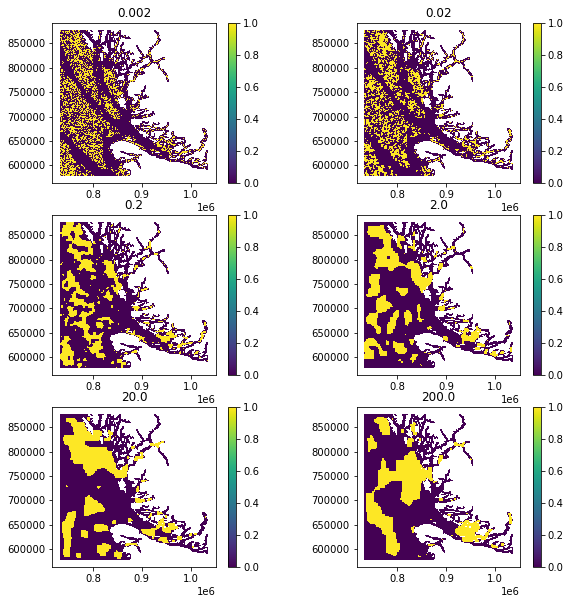

In [57]:
plotBLM(MARXAN_FOLDER, grid_file_path)